## **<font color=red ><center>Transformer 架構</center></font>** 

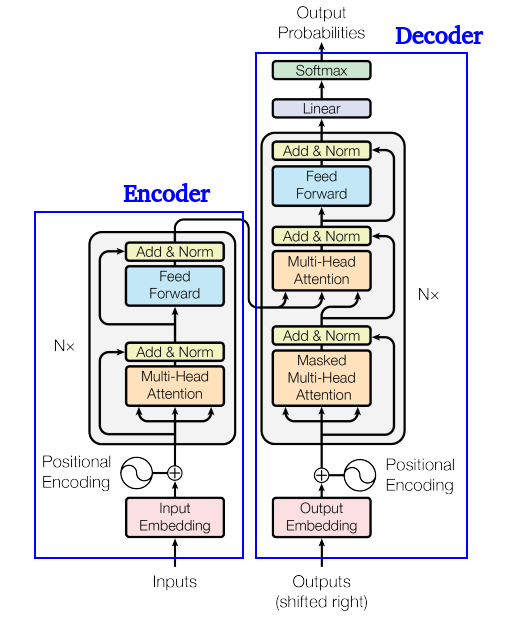

## **<font color=red ><center>Multi-Head Attention 架構</center></font>** 

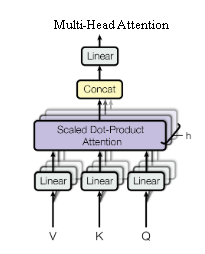

## **<font color=red ><center>Multi-Head Attention 公式</center></font>** 

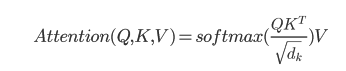

## **<font><center>Q: Query</center></font>** 
## **<font><center>K: Key</center></font>** 
## **<font><center>V: Value</center></font>** 

## **<font color=red ><center>Self-attention 架構</center></font>** 

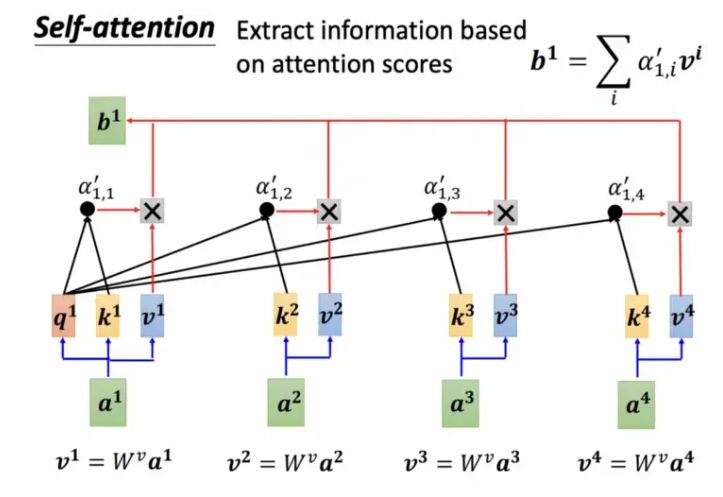

## The Transformer architecture

### Understanding self-attention

#### Generalized self-attention: the query-key-value model

### Multi-head attention

### The Transformer encoder

**Getting the data**

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  33.4M      0  0:00:02  0:00:02 --:--:-- 33.4M


**Preparing the data**

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Vectorizing the data**

In [3]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**Transformer encoder implemented as a subclassed `Layer`**

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

**Using the Transformer encoder for text classification**

In [5]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        543776    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

**Training and evaluating the Transformer encoder based model**

In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/20
625/625 [==============================] - 45s 62ms/step - loss: 0.4839 - accuracy: 0.7717 - val_loss: 0.3710 - val_accuracy: 0.8380
Epoch 2/20
625/625 [==============================] - 40s 63ms/step - loss: 0.3208 - accuracy: 0.8619 - val_loss: 0.2821 - val_accuracy: 0.8844
Epoch 3/20
625/625 [==============================] - 43s 68ms/step - loss: 0.2456 - accuracy: 0.8989 - val_loss: 0.2860 - val_accuracy: 0.8854
Epoch 4/20
625/625 [==============================] - 41s 66ms/step - loss: 0.1896 - accuracy: 0.9262 - val_loss: 0.3115 - val_accuracy: 0.8910
Epoch 5/20
625/625 [==============================] - 42s 67ms/step - loss: 0.1572 - accuracy: 0.9413 - val_loss: 0.2991 - val_accuracy: 0.8940
Epoch 6/20
625/625 [==============================] - 42s 67ms/step - loss: 0.1304 - accuracy: 0.9503 - val_loss: 0.3452 - val_accuracy: 0.8888
Epoch 7/20
625/625 [==============================] - 42s 67ms/step - loss: 0.1081 - accuracy: 0.9598 - val_loss: 0.3468 - val_accuracy:

#### Using positional encoding to re-inject order information

**Implementing positional embedding as a subclassed layer**

In [7]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### Putting it all together: A text-classification Transformer

**Combining the Transformer encoder with positional embedding**

In [8]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        5273600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder_1 (Tran  (None, None, 256)        543776    
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

### When to use sequence models over bag-of-words models?